In [15]:
import pandas as pd
import numpy as np

import snap

import ast
import pickle

%matplotlib inline

In [2]:
path = 'output/test-3/'
cluster_data = pd.read_csv(path+'1_step_user_groups.csv', sep='\t')

In [3]:
cluster_tags = pd.read_csv(path+'1_step_tags_clusters.txt', sep='\t')
cluster_tags.head()

,n_cluster,dim,hashtags
0,-1,323,/
1,0,1165,/
2,1,8,"bedtime,sleeptight,buenasnoches,bonnenuit,gute..."
3,2,5,"sleep,gutenmorgen,wakeup,goodmorningworld,toda..."
4,3,20,"dream,europa,fashionstylist,voyage,traveling,t..."


In [4]:
def getCompleteUserlist(userlist, cluster_dim):
    userlist = list(ast.literal_eval(userlist))
    result = []
    if cluster_dim > 1:
        for userdata in userlist:
            result.append(userdata[0])
    else:
        result.append(userlist[0])
    return result

In [5]:
cluster_data['all_users'] = cluster_data.apply(lambda x: getCompleteUserlist(x['list_users'], x['num_users']), axis=1)
cluster_data.head()

,id_cluster,num_users,list_users,all_users
0,1,34,"('isit5oclockyet', 0.0625), ('_mmmiriam', 0.04...","[isit5oclockyet, _mmmiriam, itirovski, mikewil..."
1,2,55,"('sachaveza', 0.09090909090909091), ('meryleda...","[sachaveza, meryledavis, maraquici, trulli_res..."
2,3,308,"('rimaglio', 1.0), ('___letizia___', 0.5), ('p...","[rimaglio, ___letizia___, pollyonvoyage, ladyf..."
3,4,45,"('becagd', 0.3333333333333333), ('erikageara',...","[becagd, erikageara, bethaniahome, manuelavern..."
4,5,353,"('billyteee', 0.5), ('lgurvichvintage', 0.3333...","[billyteee, lgurvichvintage, mr_bumper, essent..."


In [6]:
# read tags features
features = pd.read_csv('output/test-3/tagsdata.csv')
features.head()

,id_node,1,2,3,4,5,6,7,8,cluster
0,australianbrand,-0.180459,-0.316613,-1.054670,-0.132083,-0.951304,2.85555,-0.491275,0.171838,0
1,wanderlust,0.114798,-0.542545,-0.877943,-0.210757,-0.282664,2.20002,-0.619565,0.385653,0
2,turquoise,-0.187237,-0.356823,-0.704260,-0.267129,-0.680272,2.42063,-0.484453,0.255284,0
3,colour,-0.088906,-0.256796,-0.566659,-0.556371,-0.613045,2.25033,-0.449032,0.139784,0
4,lifestyle,-0.689276,-0.427289,-0.932041,-0.565373,-0.621460,2.17056,-0.488679,0.467463,-1


In [7]:
header = list(features.columns[1:9])

In [8]:
def centroid(data):
    arrays = [np.array(x[header]) for index, x in data.iterrows()]
    
    return np.sum(arrays, axis=0)/data.shape[0]

In [9]:
def closest_tags(centroid, alltags, K):
    alltags['distance'] = alltags.apply(lambda x: np.linalg.norm(np.array(x[header]) - centroid), axis=1)
    
    return alltags.sort_values(by='distance')[:K]

In [10]:
tags_to_add = features[features['cluster'].isin([-1, 0])]
tags_to_add.shape[0]

1488

In [11]:
result = []
for c in cluster_data['id_cluster']:
    cluster_centroid = centroid(features[features['cluster'] == c])

    tags_2 = closest_tags(cluster_centroid, tags_to_add, 10)
    tags_to_add.drop(tags_2.index, inplace=True, axis=0)
    
    result.append(tuple((c, list(tags_2['id_node']))))

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
extended_cluster_tags = pd.DataFrame(result, columns=['id_cluster', 'hashtags'])

In [13]:
with open('output/test-3/2_step_tags_clusters.txt', 'w') as outfile:
    outfile.write('n_cluster\thashtags\n')
    for c in extended_cluster_tags['id_cluster']:
        cluster = extended_cluster_tags[extended_cluster_tags['id_cluster'] == c]['hashtags'].values[0]
    
        outfile.write('{}\t{}\n'.format(c, ','.join(list(cluster))))

In [16]:
# extract list of tags for each user
path = 'data/test-3/'

# read input network
t_net = snap.LoadEdgeListNet(path+'hashtag_network.csv', '\t')

usedtags = {}

it = t_net.BegNI()
V = t_net.GetNodes()
for i in range(V):
    nid = it.GetId()
    type = t_net.GetStrAttrDatN(nid, 'type')
    username = t_net.GetStrAttrDatN(nid, 'content')

    if type == 'user':
        tagsV = snap.TIntV()
        snap.GetNodesAtHop(t_net, nid, 2, tagsV, True)
        
        taglist = []
        for tid in tagsV:
            tagname = t_net.GetStrAttrDatN(tid, 'content')
            taglist.append(tagname)
            
        usedtags[username] = set(taglist)
    it.Next()

In [17]:
# compute participation for the second set of tags extracted
tempResult = []
for u in usedtags:
    u_vector = usedtags[u]
    
    if len(u_vector)>0:
        u_result = [u]
        for c in extended_cluster_tags['id_cluster']:
            c_vector = set(extended_cluster_tags[extended_cluster_tags['id_cluster'] == c]['hashtags'].values[0])
            participation = float(len(u_vector.intersection(c_vector)))/len(u_vector)
            u_result.append(participation)
    else:
        u_result = [u]+[0 for i in extended_cluster_tags['id_cluster']]
    tempResult.append(tuple(u_result))

In [18]:
result_header = ['username']+[c for c in extended_cluster_tags['id_cluster']]
participationTable = pd.DataFrame(tempResult, columns=result_header)

In [19]:
participationTable.head()

,username,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,martaferrari9008,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,rsersale,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.076923,0.0,0.0,0.038462,0.000000,0.0,0.0,0.0
2,tlashab,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,charr114,0.0,0.0,0.0,0.0,0.013514,0.0,0.0,0.0,0.013514,...,0.013514,0.0,0.000000,0.0,0.0,0.000000,0.013514,0.0,0.0,0.0
4,catespin,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.041667,0.0,0.0,0.0


In [20]:
participationTable.to_csv('output/test-3/2_step_user_participation.csv', index=None)

In [21]:
first_step_users = set()
for userlist in cluster_data['all_users']:
    for u in userlist:
        first_step_users.add(u[0])

In [22]:
with open('output/test-3/2_step_user_groups.csv', 'w') as outfile:
    outfile.write('id_cluster\tnum_users\tlist_users\n')
    for i in extended_cluster_tags['id_cluster']:
        group = participationTable[participationTable[i] != 0.0]
        group.sort_values(by=i, ascending = False, inplace=True)
        
        userlist = [tuple((x['username'], x[i])) for index, x in group.iterrows() if x['username'] not in first_step_users]
        
        dim = len(userlist)
        outfile.write('{}\t{}\t{}\n'.format(i, dim, str(userlist).strip('[]')))

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Visualization of clusters and extension

In [23]:
first_step = cluster_tags.merge(cluster_data, left_on='n_cluster', right_on='id_cluster')[['id_cluster','dim','num_users']]

In [24]:
extended_cluster_tags['dim_2'] = extended_cluster_tags.apply(lambda x: len(x['hashtags']), axis=1)
extended_cluster_tags

,id_cluster,hashtags,dim_2
0,1,"[sweetdreams, buonanotte, marriage, cat, goodn...",10
1,2,"[today, bookstagram, fridayfeeling, buongiorno...",10
2,3,"[stylist, gf, wonderful, visiting, melrose, gl...",10
3,4,"[decorhome, decorationideas, inspira, mystyle,...",10
4,5,"[autumn2017, cake, tuscany, namaste, igersfire...",10
5,6,"[apoella, island, symmetry, greekdesigners, ma...",10
6,7,"[lovemylife, errejota, brasil, carshow, calili...",10
7,8,"[photography, tag, barcelona, tagsforlikes, ta...",10
8,9,"[decorating, interiordesign, architecturephoto...",10
9,10,"[alps, ski, lifewelltravelled, neverstopexplor...",10


In [25]:
user_2 = []
for i in range(1,24):
    group = participationTable[participationTable[i] != 0.0]
    group.sort_values(by=i, ascending = False, inplace=True)
    
    # filter previous users to verify how many users we are extending the clusters to
    # but in principle the participation is updates for all users and it increases for the ones of the first step!
    userlist = [tuple((x['username'], x[i])) for index, x in group.iterrows() if x['username'] not in first_step_users]

    dim = len(userlist)
    user_2.append(tuple((i, dim)))

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [26]:
second_step = first_step.merge(extended_cluster_tags[['id_cluster','dim_2']], on='id_cluster')\
                        .merge(pd.DataFrame(user_2, columns=['id_cluster', 'num_users_2']), on='id_cluster')
#second_step

In [27]:
second_step.set_index('id_cluster', inplace=True)

In [28]:
second_step.head()

,dim,num_users,dim_2,num_users_2
id_cluster,,,,
1,8,34,10,214
2,5,55,10,230
3,20,308,10,163
4,8,45,10,209
5,21,353,10,519


In [29]:
second_step.columns = ['#tag', '#users', '#tag_2', '#users_2']

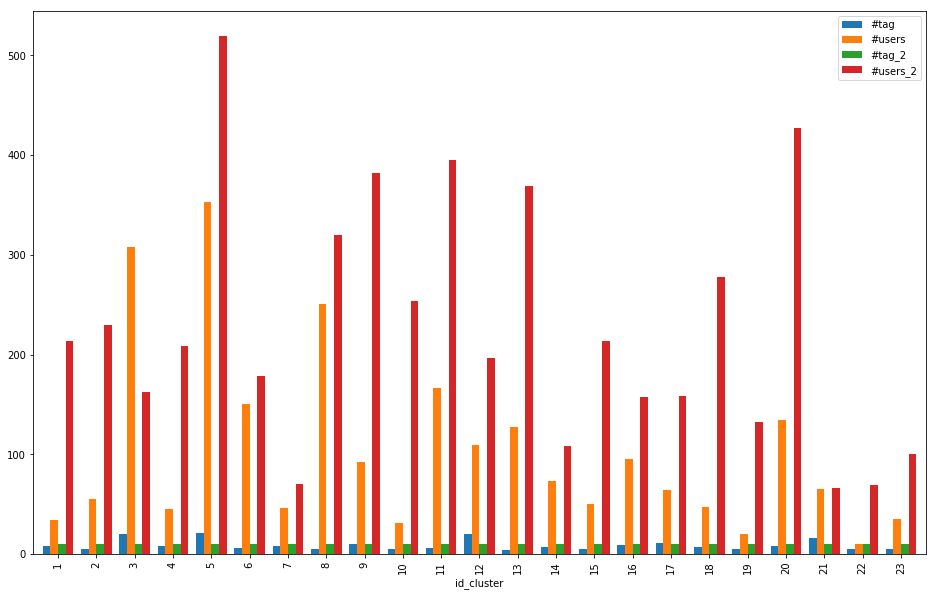

In [30]:
second_step.plot(kind='bar', figsize=(16,10), width=0.8)

Participation of the core users may increase after adding the extension

In [31]:
# compute participation for the overall hashtags cluster (core + extended)
# NB: it is possible that users have not a complete participation, since a lot of hashtags still are not included
tempResult = []
for u in usedtags:
    u_vector = usedtags[u]
    
    if len(u_vector)>0:
        u_result = [u]
        for c in extended_cluster_tags['id_cluster']:
            c_vector = set(extended_cluster_tags[extended_cluster_tags['id_cluster'] == c]['hashtags'].values[0])\
                        .union(set(cluster_tags[cluster_tags['n_cluster'] == c]['hashtags'].values[0]))
            participation = float(len(u_vector.intersection(c_vector)))/len(u_vector)
            u_result.append(participation)
    else:
        u_result = [u]+[0 for i in extended_cluster_tags['id_cluster']]
    tempResult.append(tuple(u_result))

In [32]:
result_header = ['username']+[c for c in extended_cluster_tags['id_cluster']]
participationTable = pd.DataFrame(tempResult, columns=result_header)

In [33]:
participationTable.head()

,username,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,martaferrari9008,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,rsersale,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.076923,0.0,0.0,0.038462,0.000000,0.0,0.0,0.0
2,tlashab,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,charr114,0.0,0.0,0.0,0.0,0.013514,0.0,0.0,0.0,0.013514,...,0.013514,0.0,0.000000,0.0,0.0,0.000000,0.013514,0.0,0.0,0.0
4,catespin,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.041667,0.0,0.0,0.0


In [34]:
participationTable.to_csv('output/test-3/complete_user_participation.csv', index=None)

### Community Network Visualization 

In [60]:
path = 'output/test-3/'

In [61]:
part1 = pd.read_csv(path+'1_step_user_participation.csv')
part2 = pd.read_csv(path+'2_step_user_participation.csv')

In [62]:
edgetable = []

for i in range(1,24):
    group = part1[part1[str(i)] > 0.0]
    
    
    userlist = [tuple(('core_{}'.format(i), x['username'], x[str(i)])) for index, x in group.iterrows()]
    edgetable = edgetable + userlist

for i in range(1,24):
    group = part2[part2[str(i)] > 0.0]
    
    
    userlist = [tuple(('extension_{}'.format(i), x['username'], x[str(i)])) for index, x in group.iterrows()]
    edgetable = edgetable + userlist


In [63]:
clusteredges = [tuple(('core_{}'.format(i), 'extension_{}'.format(i), 1)) for i in range(1,24)]

In [64]:
edges = pd.DataFrame(clusteredges + edgetable, columns=['source','target','weight'])
edges.to_csv('output/test-3/edgetable.csv', index=None)

In [65]:
nodes = pd.DataFrame(columns=['id', 'type'])

In [66]:
def computeSize(cluster):
    cid = int(cluster['id'].split('_')[1])

    if 'core' in cluster['id']:
        return len(cluster_tags[cluster_tags['n_cluster'] == cid]['hashtags'].values[0].split(','))
    
    elif 'extension' in cluster['id']:
        return len(list(extended_cluster_tags[extended_cluster_tags['id_cluster'] == cid]['hashtags'].values[0]))

In [67]:
def computeLabel(cluster):
    cid = int(cluster['id'].split('_')[1])
    
    if 'core' in cluster['id']:
        return cluster_tags[cluster_tags['n_cluster'] == cid]['hashtags'].values[0]
    elif 'extension' in cluster['id']:
        return ','.join(list(extended_cluster_tags[extended_cluster_tags['id_cluster'] == cid]['hashtags'].values[0]))

In [68]:
n1 = pd.DataFrame(edges['source'].unique(), columns=['id'])
n1['type'] = 'cluster'

In [69]:
n1['size'] = n1.apply(lambda x: computeSize(x), axis=1)
n1['label'] = n1.apply(lambda x: computeLabel(x), axis=1)

In [70]:
n2 = edges[['target']]
n2['type'] = 'user'
n2.columns = ['id', 'type']
n2['size'] = 1
n2['label'] = n2.apply(lambda x: x['id'], axis=1)

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [71]:
nodes = pd.concat([n1, n2])
nodes.drop_duplicates().to_csv('output/test-3/nodetable.csv', index=None)

## Number of neighbors hashtags to consider

In [ ]:
 usedtags = pickle.load(open('output/user-tags-list.pkl', 'r'))
def k_selection(max_K, tags_to_add):
    k_vec = range(10, max_K)
    added_users = []
    
    for k in k_vec:
        print k
        result = []
        for c in cluster_data['id_cluster']:
            cluster_centroid = centroid(features[features['cluster'] == c])

            tags_2 = closest_tags(cluster_centroid, tags_to_add, k)
            tags_to_add.drop(tags_2.index, inplace=True, axis=0)

            result.append(tuple((c, list(tags_2['id_node']))))
            
        extended_cluster_tags = pd.DataFrame(result, columns=['id_cluster', 'hashtags'])

        curr_added_users = []
        for c in extended_cluster_tags['id_cluster']:
            c_vector = set(extended_cluster_tags[extended_cluster_tags['id_cluster'] == c]['hashtags'].values[0])
            num_users = 0
            for u in usedtags:
                u_vector = usedtags[u]

                if len(u_vector)>0:
                    u_result = [u]
                    participation = float(len(u_vector.intersection(c_vector)))/len(u_vector)
                    
                    if participation > 0.0:
                        num_users += 1
                        
            curr_added_users.append(num_users)
        
        added_users.append(np.mean(curr_added_users))
        
    return added_users

In [ ]:
# average number of users per cluster added in the second run
k_selection(15, features[features['cluster'].isin([-1, 0])])